In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
# Parameters
input_dim = 784
n_l1 = 1000
n_l2 = 1000
z_dim = 2
batch_size = 100
n_epochs = 1000
learning_rate = 0.001
beta1 = 0.9
gpu=True

In [6]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

In [7]:
# мои правки FullyConnected из GAN
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn)
            # нам не нужен дропаут и функция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [8]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        self.fce = FullyConnected([input_dim, n_l1, n_l2, z_dim], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)
        self.fcd = FullyConnected([z_dim, n_l2, n_l1, input_dim], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.loss_fn=F.mse_loss
        self._loss = None
        
        if gpu:
            self.to(device)
        
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
            self.fce.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
            self.fce.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
            self.fce.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
            self.fce.optim = optim.Adam(self.parameters(), **optim_params)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.encode(x)
        target = self.fcd(h)
        return target
    
    def encode(self, x):
        z = self.fce(x)
        return z
    
    def decode(self, h):
        with torch.no_grad():
            return self.fcd(h)
   
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [9]:
models = {'AE2': Net(z_dim, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=learning_rate)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [10]:
D = FullyConnected([z_dim, n_l1, n_l2, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)
D.to(device)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate)

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        z_real_dist = np.random.randn(batch_size, z_dim)
        z_real_dist = torch.tensor(z_real_dist).float().to(device)
        data = data.to(device)
        for model in models.values():
            # Reconstruction phase:
            model.optim.zero_grad()
            model.fce.optim.zero_grad()
            D.zero_grad()
            output = model(data)
            encoder_output = model.fce(data)
            autoencoder_loss = model.loss(output, data)
            autoencoder_loss.backward()
            model.optim.step()
            
            #Regularization phase:
            # Discriminator
            model.optim.zero_grad()
            model.fce.optim.zero_grad()
            D.zero_grad()
            d_fake = D(encoder_output)
            d_real = D(z_real_dist)
            dc_loss_real = F.binary_cross_entropy_with_logits(d_real, torch.ones_like(d_real))
            dc_loss_fake = F.binary_cross_entropy_with_logits(d_fake, torch.zeros_like(d_fake))
            dc_loss = dc_loss_fake + dc_loss_real
            D.dc_loss = dc_loss
            dc_loss.backward(retain_graph=True)            
            D_optimizer.step()
            
            # Encoder (Generator)
            model.optim.zero_grad()
            model.fce.optim.zero_grad()
            D.zero_grad()

            d_fake = D(encoder_output)
            generator_loss = F.binary_cross_entropy_with_logits(d_fake, torch.ones_like(d_fake))
            model.fce.loss = generator_loss
            generator_loss.backward()            
            model.fce.optim.step()       
            
            
            
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f} G: {:.6f}'.format(k, m._loss.item(),  m.fce.loss.item()) for k, m in models.items()])
            losses = f'{losses} D: {D.dc_loss:.6f}'
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss))
        print(line + losses)

In [12]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += 0
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [13]:
for epoch in range(1, n_epochs + 1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses AE2: 0.937306 G: 0.798255 D: 1.398625
Train Epoch: 1 [20000/50000 (40%)]	Losses AE2: 0.218462 G: 0.808263 D: 1.388141
Train Epoch: 1 [40000/50000 (80%)]	Losses AE2: 0.196657 G: 0.725078 D: 1.389930
Train Epoch: 1 [50000/50000 (100%)]	Losses AE2: 0.197941
Test set:
AE2: loss: 0.1956	rho_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses AE2: 0.202298 G: 0.708425 D: 1.395626
Train Epoch: 2 [20000/50000 (40%)]	Losses AE2: 0.199440 G: 0.711488 D: 1.372953
Train Epoch: 2 [40000/50000 (80%)]	Losses AE2: 0.188781 G: 0.674081 D: 1.379279
Train Epoch: 2 [50000/50000 (100%)]	Losses AE2: 0.191338
Test set:
AE2: loss: 0.1869	rho_loss: 0.0000

Train Epoch: 3 [0/50000 (0%)]	Losses AE2: 0.173400 G: 0.684823 D: 1.376514
Train Epoch: 3 [20000/50000 (40%)]	Losses AE2: 0.198035 G: 0.699921 D: 1.400011
Train Epoch: 3 [40000/50000 (80%)]	Losses AE2: 0.179240 G: 0.666399 D: 1.405671
Train Epoch: 3 [50000/50000 (100%)]	Losses AE2: 0.190288
Test set:
AE2: loss: 0.1897	rho_

Train Epoch: 25 [20000/50000 (40%)]	Losses AE2: 0.180264 G: 0.697044 D: 1.391193
Train Epoch: 25 [40000/50000 (80%)]	Losses AE2: 0.179536 G: 0.696014 D: 1.379637
Train Epoch: 25 [50000/50000 (100%)]	Losses AE2: 0.191159
Test set:
AE2: loss: 0.1820	rho_loss: 0.0000

Train Epoch: 26 [0/50000 (0%)]	Losses AE2: 0.185630 G: 0.707900 D: 1.382058
Train Epoch: 26 [20000/50000 (40%)]	Losses AE2: 0.192443 G: 0.688526 D: 1.388103
Train Epoch: 26 [40000/50000 (80%)]	Losses AE2: 0.186225 G: 0.699789 D: 1.387400
Train Epoch: 26 [50000/50000 (100%)]	Losses AE2: 0.206924
Test set:
AE2: loss: 0.1768	rho_loss: 0.0000

Train Epoch: 27 [0/50000 (0%)]	Losses AE2: 0.191730 G: 0.699242 D: 1.381396
Train Epoch: 27 [20000/50000 (40%)]	Losses AE2: 0.192771 G: 0.698244 D: 1.390034
Train Epoch: 27 [40000/50000 (80%)]	Losses AE2: 0.184696 G: 0.697065 D: 1.388868
Train Epoch: 27 [50000/50000 (100%)]	Losses AE2: 0.192445
Test set:
AE2: loss: 0.1802	rho_loss: 0.0000

Train Epoch: 28 [0/50000 (0%)]	Losses AE2: 0.20300

Train Epoch: 49 [20000/50000 (40%)]	Losses AE2: 0.218585 G: 0.683320 D: 1.391765
Train Epoch: 49 [40000/50000 (80%)]	Losses AE2: 0.228703 G: 0.839405 D: 1.373209
Train Epoch: 49 [50000/50000 (100%)]	Losses AE2: 0.264384
Test set:
AE2: loss: 0.2150	rho_loss: 0.0000

Train Epoch: 50 [0/50000 (0%)]	Losses AE2: 0.211833 G: 0.881505 D: 1.292417
Train Epoch: 50 [20000/50000 (40%)]	Losses AE2: 0.262228 G: 1.182057 D: 1.205930
Train Epoch: 50 [40000/50000 (80%)]	Losses AE2: 0.246397 G: 0.719611 D: 1.362570
Train Epoch: 50 [50000/50000 (100%)]	Losses AE2: 0.214240
Test set:
AE2: loss: 0.2113	rho_loss: 0.0000

Train Epoch: 51 [0/50000 (0%)]	Losses AE2: 0.231416 G: 0.956284 D: 1.272946
Train Epoch: 51 [20000/50000 (40%)]	Losses AE2: 0.203290 G: 0.744499 D: 1.340210
Train Epoch: 51 [40000/50000 (80%)]	Losses AE2: 0.204625 G: 0.740670 D: 1.344836
Train Epoch: 51 [50000/50000 (100%)]	Losses AE2: 0.201426
Test set:
AE2: loss: 0.2008	rho_loss: 0.0000

Train Epoch: 52 [0/50000 (0%)]	Losses AE2: 0.19898

Train Epoch: 73 [20000/50000 (40%)]	Losses AE2: 0.203508 G: 0.766401 D: 1.363144
Train Epoch: 73 [40000/50000 (80%)]	Losses AE2: 0.221300 G: 0.683570 D: 1.382098
Train Epoch: 73 [50000/50000 (100%)]	Losses AE2: 0.204425
Test set:
AE2: loss: 0.2023	rho_loss: 0.0000

Train Epoch: 74 [0/50000 (0%)]	Losses AE2: 0.205484 G: 0.752318 D: 1.355515
Train Epoch: 74 [20000/50000 (40%)]	Losses AE2: 0.205943 G: 1.102299 D: 1.263988
Train Epoch: 74 [40000/50000 (80%)]	Losses AE2: 0.219656 G: 0.727327 D: 1.369385
Train Epoch: 74 [50000/50000 (100%)]	Losses AE2: 0.206354
Test set:
AE2: loss: 0.2091	rho_loss: 0.0000

Train Epoch: 75 [0/50000 (0%)]	Losses AE2: 0.208191 G: 0.772213 D: 1.363457
Train Epoch: 75 [20000/50000 (40%)]	Losses AE2: 0.222060 G: 0.758367 D: 1.364795
Train Epoch: 75 [40000/50000 (80%)]	Losses AE2: 0.217100 G: 0.792255 D: 1.345652
Train Epoch: 75 [50000/50000 (100%)]	Losses AE2: 0.220959
Test set:
AE2: loss: 0.2075	rho_loss: 0.0000

Train Epoch: 76 [0/50000 (0%)]	Losses AE2: 0.21265

Train Epoch: 97 [20000/50000 (40%)]	Losses AE2: 0.212850 G: 0.693880 D: 1.362201
Train Epoch: 97 [40000/50000 (80%)]	Losses AE2: 0.208192 G: 0.765795 D: 1.349035
Train Epoch: 97 [50000/50000 (100%)]	Losses AE2: 0.233564
Test set:
AE2: loss: 0.2114	rho_loss: 0.0000

Train Epoch: 98 [0/50000 (0%)]	Losses AE2: 0.224739 G: 0.775290 D: 1.357002
Train Epoch: 98 [20000/50000 (40%)]	Losses AE2: 0.214356 G: 0.684396 D: 1.391007
Train Epoch: 98 [40000/50000 (80%)]	Losses AE2: 0.219457 G: 0.659493 D: 1.422877
Train Epoch: 98 [50000/50000 (100%)]	Losses AE2: 0.235567
Test set:
AE2: loss: 0.2126	rho_loss: 0.0000

Train Epoch: 99 [0/50000 (0%)]	Losses AE2: 0.226932 G: 0.702847 D: 1.379106
Train Epoch: 99 [20000/50000 (40%)]	Losses AE2: 0.216586 G: 0.790481 D: 1.360499
Train Epoch: 99 [40000/50000 (80%)]	Losses AE2: 0.226544 G: 0.730404 D: 1.371015
Train Epoch: 99 [50000/50000 (100%)]	Losses AE2: 0.225060
Test set:
AE2: loss: 0.2270	rho_loss: 0.0000

Train Epoch: 100 [0/50000 (0%)]	Losses AE2: 0.2262

Train Epoch: 121 [20000/50000 (40%)]	Losses AE2: 0.210206 G: 0.703223 D: 1.377955
Train Epoch: 121 [40000/50000 (80%)]	Losses AE2: 0.227237 G: 0.710668 D: 1.354534
Train Epoch: 121 [50000/50000 (100%)]	Losses AE2: 0.229549
Test set:
AE2: loss: 0.2100	rho_loss: 0.0000

Train Epoch: 122 [0/50000 (0%)]	Losses AE2: 0.221713 G: 0.781678 D: 1.352612
Train Epoch: 122 [20000/50000 (40%)]	Losses AE2: 0.218633 G: 0.691542 D: 1.397143
Train Epoch: 122 [40000/50000 (80%)]	Losses AE2: 0.238305 G: 0.854595 D: 1.365772
Train Epoch: 122 [50000/50000 (100%)]	Losses AE2: 0.231265
Test set:
AE2: loss: 0.2349	rho_loss: 0.0000

Train Epoch: 123 [0/50000 (0%)]	Losses AE2: 0.241862 G: 0.732893 D: 1.349567
Train Epoch: 123 [20000/50000 (40%)]	Losses AE2: 0.243417 G: 0.962995 D: 1.352100
Train Epoch: 123 [40000/50000 (80%)]	Losses AE2: 0.223222 G: 0.846865 D: 1.322272
Train Epoch: 123 [50000/50000 (100%)]	Losses AE2: 0.217963
Test set:
AE2: loss: 0.2093	rho_loss: 0.0000

Train Epoch: 124 [0/50000 (0%)]	Losses 

Train Epoch: 145 [20000/50000 (40%)]	Losses AE2: 0.223462 G: 0.778025 D: 1.369906
Train Epoch: 145 [40000/50000 (80%)]	Losses AE2: 0.209646 G: 0.712550 D: 1.355609
Train Epoch: 145 [50000/50000 (100%)]	Losses AE2: 0.221424
Test set:
AE2: loss: 0.2088	rho_loss: 0.0000

Train Epoch: 146 [0/50000 (0%)]	Losses AE2: 0.222030 G: 0.802103 D: 1.334325
Train Epoch: 146 [20000/50000 (40%)]	Losses AE2: 0.198401 G: 0.790633 D: 1.357183
Train Epoch: 146 [40000/50000 (80%)]	Losses AE2: 0.202792 G: 0.661885 D: 1.410571
Train Epoch: 146 [50000/50000 (100%)]	Losses AE2: 0.212143
Test set:
AE2: loss: 0.2316	rho_loss: 0.0000

Train Epoch: 147 [0/50000 (0%)]	Losses AE2: 0.237483 G: 0.741925 D: 1.368164
Train Epoch: 147 [20000/50000 (40%)]	Losses AE2: 0.234140 G: 0.739730 D: 1.371251
Train Epoch: 147 [40000/50000 (80%)]	Losses AE2: 0.226927 G: 0.795638 D: 1.349917
Train Epoch: 147 [50000/50000 (100%)]	Losses AE2: 0.263262
Test set:
AE2: loss: 0.2704	rho_loss: 0.0000

Train Epoch: 148 [0/50000 (0%)]	Losses 

Train Epoch: 169 [20000/50000 (40%)]	Losses AE2: 0.204390 G: 0.810110 D: 1.319901
Train Epoch: 169 [40000/50000 (80%)]	Losses AE2: 0.210079 G: 0.860385 D: 1.338863
Train Epoch: 169 [50000/50000 (100%)]	Losses AE2: 0.198096
Test set:
AE2: loss: 0.1937	rho_loss: 0.0000

Train Epoch: 170 [0/50000 (0%)]	Losses AE2: 0.199751 G: 0.892973 D: 1.289411
Train Epoch: 170 [20000/50000 (40%)]	Losses AE2: 0.219578 G: 0.906605 D: 1.373380
Train Epoch: 170 [40000/50000 (80%)]	Losses AE2: 0.219624 G: 0.887504 D: 1.317718
Train Epoch: 170 [50000/50000 (100%)]	Losses AE2: 0.198326
Test set:
AE2: loss: 0.2194	rho_loss: 0.0000

Train Epoch: 171 [0/50000 (0%)]	Losses AE2: 0.227813 G: 0.886023 D: 1.282895
Train Epoch: 171 [20000/50000 (40%)]	Losses AE2: 0.214083 G: 0.715636 D: 1.387014
Train Epoch: 171 [40000/50000 (80%)]	Losses AE2: 0.221696 G: 0.880536 D: 1.316236
Train Epoch: 171 [50000/50000 (100%)]	Losses AE2: 0.242995
Test set:
AE2: loss: 0.2306	rho_loss: 0.0000

Train Epoch: 172 [0/50000 (0%)]	Losses 

Train Epoch: 193 [20000/50000 (40%)]	Losses AE2: 0.221353 G: 0.762085 D: 1.418723
Train Epoch: 193 [40000/50000 (80%)]	Losses AE2: 0.208859 G: 0.802084 D: 1.349171
Train Epoch: 193 [50000/50000 (100%)]	Losses AE2: 0.224772
Test set:
AE2: loss: 0.2173	rho_loss: 0.0000

Train Epoch: 194 [0/50000 (0%)]	Losses AE2: 0.223130 G: 0.705090 D: 1.419115
Train Epoch: 194 [20000/50000 (40%)]	Losses AE2: 0.218329 G: 0.828967 D: 1.330078
Train Epoch: 194 [40000/50000 (80%)]	Losses AE2: 0.224505 G: 1.133346 D: 1.331147
Train Epoch: 194 [50000/50000 (100%)]	Losses AE2: 0.232597
Test set:
AE2: loss: 0.2218	rho_loss: 0.0000

Train Epoch: 195 [0/50000 (0%)]	Losses AE2: 0.220753 G: 0.950677 D: 1.296759
Train Epoch: 195 [20000/50000 (40%)]	Losses AE2: 0.233431 G: 0.993773 D: 1.294691
Train Epoch: 195 [40000/50000 (80%)]	Losses AE2: 0.224209 G: 0.849970 D: 1.334605
Train Epoch: 195 [50000/50000 (100%)]	Losses AE2: 0.227535
Test set:
AE2: loss: 0.2381	rho_loss: 0.0000

Train Epoch: 196 [0/50000 (0%)]	Losses 

Train Epoch: 217 [20000/50000 (40%)]	Losses AE2: 0.218094 G: 0.719562 D: 1.384151
Train Epoch: 217 [40000/50000 (80%)]	Losses AE2: 0.217853 G: 0.807237 D: 1.397427
Train Epoch: 217 [50000/50000 (100%)]	Losses AE2: 0.216998
Test set:
AE2: loss: 0.2047	rho_loss: 0.0000

Train Epoch: 218 [0/50000 (0%)]	Losses AE2: 0.217407 G: 0.842904 D: 1.310760
Train Epoch: 218 [20000/50000 (40%)]	Losses AE2: 0.216443 G: 0.803218 D: 1.328975
Train Epoch: 218 [40000/50000 (80%)]	Losses AE2: 0.212504 G: 0.842557 D: 1.303989
Train Epoch: 218 [50000/50000 (100%)]	Losses AE2: 0.209203
Test set:
AE2: loss: 0.2103	rho_loss: 0.0000

Train Epoch: 219 [0/50000 (0%)]	Losses AE2: 0.208071 G: 0.761198 D: 1.381885
Train Epoch: 219 [20000/50000 (40%)]	Losses AE2: 0.217272 G: 0.887682 D: 1.337659
Train Epoch: 219 [40000/50000 (80%)]	Losses AE2: 0.207044 G: 0.729587 D: 1.403146
Train Epoch: 219 [50000/50000 (100%)]	Losses AE2: 0.213079
Test set:
AE2: loss: 0.2052	rho_loss: 0.0000

Train Epoch: 220 [0/50000 (0%)]	Losses 

Train Epoch: 241 [20000/50000 (40%)]	Losses AE2: 0.219963 G: 0.803436 D: 1.383313
Train Epoch: 241 [40000/50000 (80%)]	Losses AE2: 0.208613 G: 0.868110 D: 1.291057
Train Epoch: 241 [50000/50000 (100%)]	Losses AE2: 0.217735
Test set:
AE2: loss: 0.2159	rho_loss: 0.0000

Train Epoch: 242 [0/50000 (0%)]	Losses AE2: 0.212808 G: 0.765178 D: 1.350041
Train Epoch: 242 [20000/50000 (40%)]	Losses AE2: 0.205125 G: 0.803675 D: 1.382483
Train Epoch: 242 [40000/50000 (80%)]	Losses AE2: 0.236987 G: 0.852167 D: 1.315819
Train Epoch: 242 [50000/50000 (100%)]	Losses AE2: 0.243086
Test set:
AE2: loss: 0.2178	rho_loss: 0.0000

Train Epoch: 243 [0/50000 (0%)]	Losses AE2: 0.215633 G: 0.928388 D: 1.328814
Train Epoch: 243 [20000/50000 (40%)]	Losses AE2: 0.202611 G: 0.725370 D: 1.366692
Train Epoch: 243 [40000/50000 (80%)]	Losses AE2: 0.202599 G: 0.889387 D: 1.309637
Train Epoch: 243 [50000/50000 (100%)]	Losses AE2: 0.219680
Test set:
AE2: loss: 0.2078	rho_loss: 0.0000

Train Epoch: 244 [0/50000 (0%)]	Losses 

Train Epoch: 265 [20000/50000 (40%)]	Losses AE2: 0.229958 G: 0.667104 D: 1.390500
Train Epoch: 265 [40000/50000 (80%)]	Losses AE2: 0.195723 G: 0.725583 D: 1.374160
Train Epoch: 265 [50000/50000 (100%)]	Losses AE2: 0.199661
Test set:
AE2: loss: 0.2250	rho_loss: 0.0000

Train Epoch: 266 [0/50000 (0%)]	Losses AE2: 0.229478 G: 0.717660 D: 1.368863
Train Epoch: 266 [20000/50000 (40%)]	Losses AE2: 0.209885 G: 0.715015 D: 1.388061
Train Epoch: 266 [40000/50000 (80%)]	Losses AE2: 0.208249 G: 0.696454 D: 1.392303
Train Epoch: 266 [50000/50000 (100%)]	Losses AE2: 0.208576
Test set:
AE2: loss: 0.2018	rho_loss: 0.0000

Train Epoch: 267 [0/50000 (0%)]	Losses AE2: 0.205174 G: 0.690144 D: 1.392154
Train Epoch: 267 [20000/50000 (40%)]	Losses AE2: 0.205761 G: 0.727062 D: 1.367853
Train Epoch: 267 [40000/50000 (80%)]	Losses AE2: 0.193650 G: 0.700569 D: 1.378361
Train Epoch: 267 [50000/50000 (100%)]	Losses AE2: 0.216723
Test set:
AE2: loss: 0.2202	rho_loss: 0.0000

Train Epoch: 268 [0/50000 (0%)]	Losses 

Train Epoch: 289 [20000/50000 (40%)]	Losses AE2: 0.213845 G: 0.736693 D: 1.360953
Train Epoch: 289 [40000/50000 (80%)]	Losses AE2: 0.210912 G: 0.701665 D: 1.389339
Train Epoch: 289 [50000/50000 (100%)]	Losses AE2: 0.213374
Test set:
AE2: loss: 0.2124	rho_loss: 0.0000

Train Epoch: 290 [0/50000 (0%)]	Losses AE2: 0.223215 G: 0.742030 D: 1.389155
Train Epoch: 290 [20000/50000 (40%)]	Losses AE2: 0.229164 G: 0.692471 D: 1.385613
Train Epoch: 290 [40000/50000 (80%)]	Losses AE2: 0.217402 G: 0.695938 D: 1.363283
Train Epoch: 290 [50000/50000 (100%)]	Losses AE2: 0.235841
Test set:
AE2: loss: 0.2295	rho_loss: 0.0000

Train Epoch: 291 [0/50000 (0%)]	Losses AE2: 0.242055 G: 0.738997 D: 1.370774
Train Epoch: 291 [20000/50000 (40%)]	Losses AE2: 0.219307 G: 0.690603 D: 1.388330
Train Epoch: 291 [40000/50000 (80%)]	Losses AE2: 0.201419 G: 0.741665 D: 1.360297
Train Epoch: 291 [50000/50000 (100%)]	Losses AE2: 0.229545
Test set:
AE2: loss: 0.2185	rho_loss: 0.0000

Train Epoch: 292 [0/50000 (0%)]	Losses 

Train Epoch: 313 [20000/50000 (40%)]	Losses AE2: 0.204109 G: 0.860402 D: 1.323570
Train Epoch: 313 [40000/50000 (80%)]	Losses AE2: 0.224469 G: 0.833665 D: 1.326578
Train Epoch: 313 [50000/50000 (100%)]	Losses AE2: 0.227690
Test set:
AE2: loss: 0.2111	rho_loss: 0.0000

Train Epoch: 314 [0/50000 (0%)]	Losses AE2: 0.207351 G: 0.860139 D: 1.309020
Train Epoch: 314 [20000/50000 (40%)]	Losses AE2: 0.239617 G: 0.772908 D: 1.363351
Train Epoch: 314 [40000/50000 (80%)]	Losses AE2: 0.221749 G: 0.809464 D: 1.363703
Train Epoch: 314 [50000/50000 (100%)]	Losses AE2: 0.219972
Test set:
AE2: loss: 0.2176	rho_loss: 0.0000

Train Epoch: 315 [0/50000 (0%)]	Losses AE2: 0.228559 G: 0.895327 D: 1.337939
Train Epoch: 315 [20000/50000 (40%)]	Losses AE2: 0.233188 G: 0.757462 D: 1.405025
Train Epoch: 315 [40000/50000 (80%)]	Losses AE2: 0.247178 G: 0.755683 D: 1.378190
Train Epoch: 315 [50000/50000 (100%)]	Losses AE2: 0.244019
Test set:
AE2: loss: 0.2558	rho_loss: 0.0000

Train Epoch: 316 [0/50000 (0%)]	Losses 

Train Epoch: 337 [20000/50000 (40%)]	Losses AE2: 0.212997 G: 0.859334 D: 1.318810
Train Epoch: 337 [40000/50000 (80%)]	Losses AE2: 0.217446 G: 0.722259 D: 1.397866
Train Epoch: 337 [50000/50000 (100%)]	Losses AE2: 0.198026
Test set:
AE2: loss: 0.2127	rho_loss: 0.0000

Train Epoch: 338 [0/50000 (0%)]	Losses AE2: 0.203060 G: 0.678616 D: 1.398027
Train Epoch: 338 [20000/50000 (40%)]	Losses AE2: 0.217818 G: 0.829146 D: 1.322797
Train Epoch: 338 [40000/50000 (80%)]	Losses AE2: 0.228834 G: 0.814929 D: 1.320813
Train Epoch: 338 [50000/50000 (100%)]	Losses AE2: 0.222176
Test set:
AE2: loss: 0.2194	rho_loss: 0.0000

Train Epoch: 339 [0/50000 (0%)]	Losses AE2: 0.223280 G: 0.748409 D: 1.366591
Train Epoch: 339 [20000/50000 (40%)]	Losses AE2: 0.223595 G: 0.682286 D: 1.385186
Train Epoch: 339 [40000/50000 (80%)]	Losses AE2: 0.251302 G: 0.790068 D: 1.460303
Train Epoch: 339 [50000/50000 (100%)]	Losses AE2: 0.228583
Test set:
AE2: loss: 0.2288	rho_loss: 0.0000

Train Epoch: 340 [0/50000 (0%)]	Losses 

Train Epoch: 361 [20000/50000 (40%)]	Losses AE2: 0.261204 G: 0.687695 D: 1.589110
Train Epoch: 361 [40000/50000 (80%)]	Losses AE2: 0.233453 G: 0.678709 D: 1.418051
Train Epoch: 361 [50000/50000 (100%)]	Losses AE2: 0.202642
Test set:
AE2: loss: 0.2014	rho_loss: 0.0000

Train Epoch: 362 [0/50000 (0%)]	Losses AE2: 0.201600 G: 0.791924 D: 1.329503
Train Epoch: 362 [20000/50000 (40%)]	Losses AE2: 0.206619 G: 0.710362 D: 1.393865
Train Epoch: 362 [40000/50000 (80%)]	Losses AE2: 0.187803 G: 0.741367 D: 1.382929
Train Epoch: 362 [50000/50000 (100%)]	Losses AE2: 0.207659
Test set:
AE2: loss: 0.1982	rho_loss: 0.0000

Train Epoch: 363 [0/50000 (0%)]	Losses AE2: 0.206611 G: 0.873577 D: 1.327666
Train Epoch: 363 [20000/50000 (40%)]	Losses AE2: 0.222668 G: 0.737885 D: 1.383925
Train Epoch: 363 [40000/50000 (80%)]	Losses AE2: 0.228986 G: 0.833943 D: 1.357931
Train Epoch: 363 [50000/50000 (100%)]	Losses AE2: 0.235180
Test set:
AE2: loss: 0.2230	rho_loss: 0.0000

Train Epoch: 364 [0/50000 (0%)]	Losses 

Train Epoch: 385 [20000/50000 (40%)]	Losses AE2: 0.228989 G: 0.785216 D: 1.314502
Train Epoch: 385 [40000/50000 (80%)]	Losses AE2: 0.225025 G: 0.684016 D: 1.375162
Train Epoch: 385 [50000/50000 (100%)]	Losses AE2: 0.199360
Test set:
AE2: loss: 0.2045	rho_loss: 0.0000

Train Epoch: 386 [0/50000 (0%)]	Losses AE2: 0.201128 G: 0.703397 D: 1.374970
Train Epoch: 386 [20000/50000 (40%)]	Losses AE2: 0.217640 G: 0.769207 D: 1.378004
Train Epoch: 386 [40000/50000 (80%)]	Losses AE2: 0.207676 G: 0.728978 D: 1.366648
Train Epoch: 386 [50000/50000 (100%)]	Losses AE2: 0.198759
Test set:
AE2: loss: 0.1996	rho_loss: 0.0000

Train Epoch: 387 [0/50000 (0%)]	Losses AE2: 0.206827 G: 0.727651 D: 1.393988
Train Epoch: 387 [20000/50000 (40%)]	Losses AE2: 0.207539 G: 0.686001 D: 1.409382
Train Epoch: 387 [40000/50000 (80%)]	Losses AE2: 0.200345 G: 0.751141 D: 1.361051
Train Epoch: 387 [50000/50000 (100%)]	Losses AE2: 0.213135
Test set:
AE2: loss: 0.2048	rho_loss: 0.0000

Train Epoch: 388 [0/50000 (0%)]	Losses 

Train Epoch: 409 [20000/50000 (40%)]	Losses AE2: 0.228104 G: 0.663289 D: 1.425544
Train Epoch: 409 [40000/50000 (80%)]	Losses AE2: 0.211952 G: 0.973662 D: 1.261597
Train Epoch: 409 [50000/50000 (100%)]	Losses AE2: 0.197202
Test set:
AE2: loss: 0.2189	rho_loss: 0.0000

Train Epoch: 410 [0/50000 (0%)]	Losses AE2: 0.209474 G: 0.719049 D: 1.350943
Train Epoch: 410 [20000/50000 (40%)]	Losses AE2: 0.222118 G: 0.717726 D: 1.380136
Train Epoch: 410 [40000/50000 (80%)]	Losses AE2: 0.233229 G: 0.745784 D: 1.383295
Train Epoch: 410 [50000/50000 (100%)]	Losses AE2: 0.219186
Test set:
AE2: loss: 0.2072	rho_loss: 0.0000

Train Epoch: 411 [0/50000 (0%)]	Losses AE2: 0.219390 G: 0.798298 D: 1.358797
Train Epoch: 411 [20000/50000 (40%)]	Losses AE2: 0.217696 G: 0.691472 D: 1.393627
Train Epoch: 411 [40000/50000 (80%)]	Losses AE2: 0.233555 G: 0.786638 D: 1.354924
Train Epoch: 411 [50000/50000 (100%)]	Losses AE2: 0.253605
Test set:
AE2: loss: 0.2606	rho_loss: 0.0000

Train Epoch: 412 [0/50000 (0%)]	Losses 

Train Epoch: 433 [20000/50000 (40%)]	Losses AE2: 0.206139 G: 0.771779 D: 1.359757
Train Epoch: 433 [40000/50000 (80%)]	Losses AE2: 0.204515 G: 0.836830 D: 1.320987
Train Epoch: 433 [50000/50000 (100%)]	Losses AE2: 0.209013
Test set:
AE2: loss: 0.2021	rho_loss: 0.0000

Train Epoch: 434 [0/50000 (0%)]	Losses AE2: 0.207335 G: 0.739367 D: 1.403394
Train Epoch: 434 [20000/50000 (40%)]	Losses AE2: 0.215740 G: 0.858742 D: 1.351741
Train Epoch: 434 [40000/50000 (80%)]	Losses AE2: 0.235382 G: 0.873217 D: 1.314797
Train Epoch: 434 [50000/50000 (100%)]	Losses AE2: 0.223395
Test set:
AE2: loss: 0.2225	rho_loss: 0.0000

Train Epoch: 435 [0/50000 (0%)]	Losses AE2: 0.212556 G: 0.932061 D: 1.319644
Train Epoch: 435 [20000/50000 (40%)]	Losses AE2: 0.231296 G: 0.748987 D: 1.348348
Train Epoch: 435 [40000/50000 (80%)]	Losses AE2: 0.247392 G: 0.731894 D: 1.418393
Train Epoch: 435 [50000/50000 (100%)]	Losses AE2: 0.222901
Test set:
AE2: loss: 0.2055	rho_loss: 0.0000

Train Epoch: 436 [0/50000 (0%)]	Losses 

Train Epoch: 457 [20000/50000 (40%)]	Losses AE2: 0.219619 G: 0.758844 D: 1.347839
Train Epoch: 457 [40000/50000 (80%)]	Losses AE2: 0.245518 G: 1.052357 D: 1.308141
Train Epoch: 457 [50000/50000 (100%)]	Losses AE2: 0.225655
Test set:
AE2: loss: 0.2153	rho_loss: 0.0000

Train Epoch: 458 [0/50000 (0%)]	Losses AE2: 0.223779 G: 0.815579 D: 1.365258
Train Epoch: 458 [20000/50000 (40%)]	Losses AE2: 0.269160 G: 0.758037 D: 1.387182
Train Epoch: 458 [40000/50000 (80%)]	Losses AE2: 0.213250 G: 0.703229 D: 1.367503
Train Epoch: 458 [50000/50000 (100%)]	Losses AE2: 0.216319
Test set:
AE2: loss: 0.2118	rho_loss: 0.0000

Train Epoch: 459 [0/50000 (0%)]	Losses AE2: 0.203400 G: 0.852174 D: 1.346760
Train Epoch: 459 [20000/50000 (40%)]	Losses AE2: 0.207334 G: 0.939608 D: 1.290731
Train Epoch: 459 [40000/50000 (80%)]	Losses AE2: 0.222573 G: 0.931318 D: 1.364686
Train Epoch: 459 [50000/50000 (100%)]	Losses AE2: 0.219898
Test set:
AE2: loss: 0.2136	rho_loss: 0.0000

Train Epoch: 460 [0/50000 (0%)]	Losses 

Train Epoch: 481 [20000/50000 (40%)]	Losses AE2: 0.247030 G: 0.842559 D: 1.333662
Train Epoch: 481 [40000/50000 (80%)]	Losses AE2: 0.250805 G: 0.734170 D: 1.363187
Train Epoch: 481 [50000/50000 (100%)]	Losses AE2: 0.219534
Test set:
AE2: loss: 0.2240	rho_loss: 0.0000

Train Epoch: 482 [0/50000 (0%)]	Losses AE2: 0.229791 G: 0.795889 D: 1.349921
Train Epoch: 482 [20000/50000 (40%)]	Losses AE2: 0.235489 G: 0.955603 D: 1.323885
Train Epoch: 482 [40000/50000 (80%)]	Losses AE2: 0.234585 G: 0.672304 D: 1.398842
Train Epoch: 482 [50000/50000 (100%)]	Losses AE2: 0.204543
Test set:
AE2: loss: 0.2086	rho_loss: 0.0000

Train Epoch: 483 [0/50000 (0%)]	Losses AE2: 0.206544 G: 0.806805 D: 1.341265
Train Epoch: 483 [20000/50000 (40%)]	Losses AE2: 0.215483 G: 0.770651 D: 1.373420
Train Epoch: 483 [40000/50000 (80%)]	Losses AE2: 0.210732 G: 0.734526 D: 1.372009
Train Epoch: 483 [50000/50000 (100%)]	Losses AE2: 0.208319
Test set:
AE2: loss: 0.2016	rho_loss: 0.0000

Train Epoch: 484 [0/50000 (0%)]	Losses 

Train Epoch: 505 [20000/50000 (40%)]	Losses AE2: 0.241232 G: 0.940409 D: 1.274973
Train Epoch: 505 [40000/50000 (80%)]	Losses AE2: 0.217135 G: 0.805692 D: 1.349797
Train Epoch: 505 [50000/50000 (100%)]	Losses AE2: 0.200353
Test set:
AE2: loss: 0.2076	rho_loss: 0.0000

Train Epoch: 506 [0/50000 (0%)]	Losses AE2: 0.216808 G: 0.765408 D: 1.373819
Train Epoch: 506 [20000/50000 (40%)]	Losses AE2: 0.205882 G: 0.706402 D: 1.383216
Train Epoch: 506 [40000/50000 (80%)]	Losses AE2: 0.224706 G: 0.742907 D: 1.389734
Train Epoch: 506 [50000/50000 (100%)]	Losses AE2: 0.201900
Test set:
AE2: loss: 0.1984	rho_loss: 0.0000

Train Epoch: 507 [0/50000 (0%)]	Losses AE2: 0.209195 G: 0.953360 D: 1.325482
Train Epoch: 507 [20000/50000 (40%)]	Losses AE2: 0.215796 G: 0.722502 D: 1.409306
Train Epoch: 507 [40000/50000 (80%)]	Losses AE2: 0.208291 G: 0.766047 D: 1.444915
Train Epoch: 507 [50000/50000 (100%)]	Losses AE2: 0.224027
Test set:
AE2: loss: 0.2137	rho_loss: 0.0000

Train Epoch: 508 [0/50000 (0%)]	Losses 

Train Epoch: 529 [20000/50000 (40%)]	Losses AE2: 0.281249 G: 0.962876 D: 1.295506
Train Epoch: 529 [40000/50000 (80%)]	Losses AE2: 0.211208 G: 0.739802 D: 1.360906
Train Epoch: 529 [50000/50000 (100%)]	Losses AE2: 0.223187
Test set:
AE2: loss: 0.2049	rho_loss: 0.0000

Train Epoch: 530 [0/50000 (0%)]	Losses AE2: 0.204570 G: 0.729804 D: 1.382481
Train Epoch: 530 [20000/50000 (40%)]	Losses AE2: 0.210066 G: 0.750869 D: 1.369821
Train Epoch: 530 [40000/50000 (80%)]	Losses AE2: 0.213562 G: 0.759579 D: 1.391813
Train Epoch: 530 [50000/50000 (100%)]	Losses AE2: 0.222994
Test set:
AE2: loss: 0.2251	rho_loss: 0.0000

Train Epoch: 531 [0/50000 (0%)]	Losses AE2: 0.226297 G: 0.779617 D: 1.358941
Train Epoch: 531 [20000/50000 (40%)]	Losses AE2: 0.209873 G: 0.744137 D: 1.368544
Train Epoch: 531 [40000/50000 (80%)]	Losses AE2: 0.232513 G: 0.729632 D: 1.383228
Train Epoch: 531 [50000/50000 (100%)]	Losses AE2: 0.267014
Test set:
AE2: loss: 0.2683	rho_loss: 0.0000

Train Epoch: 532 [0/50000 (0%)]	Losses 

Train Epoch: 553 [20000/50000 (40%)]	Losses AE2: 0.268176 G: 0.709680 D: 1.410275
Train Epoch: 553 [40000/50000 (80%)]	Losses AE2: 0.227046 G: 1.006250 D: 1.306710
Train Epoch: 553 [50000/50000 (100%)]	Losses AE2: 0.217641
Test set:
AE2: loss: 0.2091	rho_loss: 0.0000

Train Epoch: 554 [0/50000 (0%)]	Losses AE2: 0.228539 G: 0.930558 D: 1.306679
Train Epoch: 554 [20000/50000 (40%)]	Losses AE2: 0.223736 G: 0.862635 D: 1.319336
Train Epoch: 554 [40000/50000 (80%)]	Losses AE2: 0.229363 G: 0.861713 D: 1.310663
Train Epoch: 554 [50000/50000 (100%)]	Losses AE2: 0.233372
Test set:
AE2: loss: 0.2164	rho_loss: 0.0000

Train Epoch: 555 [0/50000 (0%)]	Losses AE2: 0.236732 G: 0.889032 D: 1.303313
Train Epoch: 555 [20000/50000 (40%)]	Losses AE2: 0.233911 G: 0.827138 D: 1.369578
Train Epoch: 555 [40000/50000 (80%)]	Losses AE2: 0.240228 G: 0.807833 D: 1.347262
Train Epoch: 555 [50000/50000 (100%)]	Losses AE2: 0.269905
Test set:
AE2: loss: 0.2451	rho_loss: 0.0000

Train Epoch: 556 [0/50000 (0%)]	Losses 

Train Epoch: 577 [20000/50000 (40%)]	Losses AE2: 0.220165 G: 0.743637 D: 1.395329
Train Epoch: 577 [40000/50000 (80%)]	Losses AE2: 0.243177 G: 0.867768 D: 1.288691
Train Epoch: 577 [50000/50000 (100%)]	Losses AE2: 0.258286
Test set:
AE2: loss: 0.2476	rho_loss: 0.0000

Train Epoch: 578 [0/50000 (0%)]	Losses AE2: 0.260834 G: 0.819389 D: 1.327779
Train Epoch: 578 [20000/50000 (40%)]	Losses AE2: 0.279067 G: 13.622053 D: 0.297454
Train Epoch: 578 [40000/50000 (80%)]	Losses AE2: 0.214949 G: 0.864033 D: 1.326102
Train Epoch: 578 [50000/50000 (100%)]	Losses AE2: 0.196613
Test set:
AE2: loss: 0.2000	rho_loss: 0.0000

Train Epoch: 579 [0/50000 (0%)]	Losses AE2: 0.201266 G: 0.778667 D: 1.356149
Train Epoch: 579 [20000/50000 (40%)]	Losses AE2: 0.210737 G: 0.789624 D: 1.348760
Train Epoch: 579 [40000/50000 (80%)]	Losses AE2: 0.213793 G: 0.861170 D: 1.323525
Train Epoch: 579 [50000/50000 (100%)]	Losses AE2: 0.198991
Test set:
AE2: loss: 0.2061	rho_loss: 0.0000

Train Epoch: 580 [0/50000 (0%)]	Losses

Train Epoch: 601 [20000/50000 (40%)]	Losses AE2: 0.235932 G: 0.971747 D: 1.282089
Train Epoch: 601 [40000/50000 (80%)]	Losses AE2: 0.222509 G: 0.962892 D: 1.370056
Train Epoch: 601 [50000/50000 (100%)]	Losses AE2: 0.255628
Test set:
AE2: loss: 0.2378	rho_loss: 0.0000

Train Epoch: 602 [0/50000 (0%)]	Losses AE2: 0.241277 G: 0.896142 D: 1.292702
Train Epoch: 602 [20000/50000 (40%)]	Losses AE2: 0.242710 G: 0.951896 D: 1.360921
Train Epoch: 602 [40000/50000 (80%)]	Losses AE2: 0.247987 G: 1.292870 D: 1.341559
Train Epoch: 602 [50000/50000 (100%)]	Losses AE2: 0.330666
Test set:
AE2: loss: 0.2818	rho_loss: 0.0000

Train Epoch: 603 [0/50000 (0%)]	Losses AE2: 0.279965 G: 3.040064 D: 0.650823
Train Epoch: 603 [20000/50000 (40%)]	Losses AE2: 0.211208 G: 0.760930 D: 1.410296
Train Epoch: 603 [40000/50000 (80%)]	Losses AE2: 0.218170 G: 0.949504 D: 1.318869
Train Epoch: 603 [50000/50000 (100%)]	Losses AE2: 0.209290
Test set:
AE2: loss: 0.2176	rho_loss: 0.0000

Train Epoch: 604 [0/50000 (0%)]	Losses 

Train Epoch: 625 [20000/50000 (40%)]	Losses AE2: 0.212154 G: 0.725614 D: 1.350377
Train Epoch: 625 [40000/50000 (80%)]	Losses AE2: 0.224283 G: 0.729689 D: 1.400449
Train Epoch: 625 [50000/50000 (100%)]	Losses AE2: 0.216858
Test set:
AE2: loss: 0.2002	rho_loss: 0.0000

Train Epoch: 626 [0/50000 (0%)]	Losses AE2: 0.210363 G: 0.777359 D: 1.315345
Train Epoch: 626 [20000/50000 (40%)]	Losses AE2: 0.210222 G: 0.818716 D: 1.323003
Train Epoch: 626 [40000/50000 (80%)]	Losses AE2: 0.229546 G: 0.711782 D: 1.345665
Train Epoch: 626 [50000/50000 (100%)]	Losses AE2: 0.245432
Test set:
AE2: loss: 0.2181	rho_loss: 0.0000

Train Epoch: 627 [0/50000 (0%)]	Losses AE2: 0.235539 G: 0.847123 D: 1.354311
Train Epoch: 627 [20000/50000 (40%)]	Losses AE2: 0.263600 G: 1.186271 D: 1.162357
Train Epoch: 627 [40000/50000 (80%)]	Losses AE2: 0.203931 G: 0.730932 D: 1.361135
Train Epoch: 627 [50000/50000 (100%)]	Losses AE2: 0.206857
Test set:
AE2: loss: 0.2063	rho_loss: 0.0000

Train Epoch: 628 [0/50000 (0%)]	Losses 

Train Epoch: 649 [20000/50000 (40%)]	Losses AE2: 0.245653 G: 0.859620 D: 1.326004
Train Epoch: 649 [40000/50000 (80%)]	Losses AE2: 0.260811 G: 0.643435 D: 1.476804
Train Epoch: 649 [50000/50000 (100%)]	Losses AE2: 0.236824
Test set:
AE2: loss: 0.2201	rho_loss: 0.0000

Train Epoch: 650 [0/50000 (0%)]	Losses AE2: 0.219177 G: 0.770374 D: 1.379733
Train Epoch: 650 [20000/50000 (40%)]	Losses AE2: 0.253445 G: 0.723772 D: 1.442160
Train Epoch: 650 [40000/50000 (80%)]	Losses AE2: 0.218344 G: 0.857308 D: 1.319994
Train Epoch: 650 [50000/50000 (100%)]	Losses AE2: 0.220325
Test set:
AE2: loss: 0.2027	rho_loss: 0.0000

Train Epoch: 651 [0/50000 (0%)]	Losses AE2: 0.216019 G: 0.883691 D: 1.307927
Train Epoch: 651 [20000/50000 (40%)]	Losses AE2: 0.216877 G: 0.775140 D: 1.347794
Train Epoch: 651 [40000/50000 (80%)]	Losses AE2: 0.223033 G: 0.732148 D: 1.362920
Train Epoch: 651 [50000/50000 (100%)]	Losses AE2: 0.217382
Test set:
AE2: loss: 0.2120	rho_loss: 0.0000

Train Epoch: 652 [0/50000 (0%)]	Losses 

Train Epoch: 673 [20000/50000 (40%)]	Losses AE2: 0.210295 G: 0.816386 D: 1.348470
Train Epoch: 673 [40000/50000 (80%)]	Losses AE2: 0.218475 G: 0.774976 D: 1.354625
Train Epoch: 673 [50000/50000 (100%)]	Losses AE2: 0.215658
Test set:
AE2: loss: 0.2020	rho_loss: 0.0000

Train Epoch: 674 [0/50000 (0%)]	Losses AE2: 0.224173 G: 0.824124 D: 1.357096
Train Epoch: 674 [20000/50000 (40%)]	Losses AE2: 0.214443 G: 0.699167 D: 1.402659
Train Epoch: 674 [40000/50000 (80%)]	Losses AE2: 0.247537 G: 0.756266 D: 1.401167
Train Epoch: 674 [50000/50000 (100%)]	Losses AE2: 0.205692
Test set:
AE2: loss: 0.2197	rho_loss: 0.0000

Train Epoch: 675 [0/50000 (0%)]	Losses AE2: 0.227637 G: 0.676369 D: 1.383219
Train Epoch: 675 [20000/50000 (40%)]	Losses AE2: 0.207565 G: 0.767936 D: 1.339252
Train Epoch: 675 [40000/50000 (80%)]	Losses AE2: 0.206816 G: 0.718782 D: 1.376308
Train Epoch: 675 [50000/50000 (100%)]	Losses AE2: 0.206241
Test set:
AE2: loss: 0.2045	rho_loss: 0.0000

Train Epoch: 676 [0/50000 (0%)]	Losses 

Train Epoch: 697 [20000/50000 (40%)]	Losses AE2: 0.224597 G: 0.774734 D: 1.324860
Train Epoch: 697 [40000/50000 (80%)]	Losses AE2: 0.218721 G: 0.715273 D: 1.362304
Train Epoch: 697 [50000/50000 (100%)]	Losses AE2: 0.233003
Test set:
AE2: loss: 0.2343	rho_loss: 0.0000

Train Epoch: 698 [0/50000 (0%)]	Losses AE2: 0.229415 G: 0.700435 D: 1.356318
Train Epoch: 698 [20000/50000 (40%)]	Losses AE2: 0.302900 G: 2.524582 D: 1.391178
Train Epoch: 698 [40000/50000 (80%)]	Losses AE2: 0.213663 G: 0.730571 D: 1.371119
Train Epoch: 698 [50000/50000 (100%)]	Losses AE2: 0.216609
Test set:
AE2: loss: 0.2079	rho_loss: 0.0000

Train Epoch: 699 [0/50000 (0%)]	Losses AE2: 0.213164 G: 0.710943 D: 1.389651
Train Epoch: 699 [20000/50000 (40%)]	Losses AE2: 0.211555 G: 0.848117 D: 1.348017
Train Epoch: 699 [40000/50000 (80%)]	Losses AE2: 0.229622 G: 0.889682 D: 1.335171
Train Epoch: 699 [50000/50000 (100%)]	Losses AE2: 0.210539
Test set:
AE2: loss: 0.2314	rho_loss: 0.0000

Train Epoch: 700 [0/50000 (0%)]	Losses 

Train Epoch: 721 [20000/50000 (40%)]	Losses AE2: 0.220742 G: 0.688823 D: 1.387398
Train Epoch: 721 [40000/50000 (80%)]	Losses AE2: 0.198316 G: 0.697989 D: 1.378831
Train Epoch: 721 [50000/50000 (100%)]	Losses AE2: 0.214360
Test set:
AE2: loss: 0.2040	rho_loss: 0.0000

Train Epoch: 722 [0/50000 (0%)]	Losses AE2: 0.217549 G: 0.692128 D: 1.385120
Train Epoch: 722 [20000/50000 (40%)]	Losses AE2: 0.208798 G: 0.694845 D: 1.385105
Train Epoch: 722 [40000/50000 (80%)]	Losses AE2: 0.197955 G: 0.691059 D: 1.385213
Train Epoch: 722 [50000/50000 (100%)]	Losses AE2: 0.211130
Test set:
AE2: loss: 0.2149	rho_loss: 0.0000

Train Epoch: 723 [0/50000 (0%)]	Losses AE2: 0.214245 G: 0.693048 D: 1.380451
Train Epoch: 723 [20000/50000 (40%)]	Losses AE2: 0.201770 G: 0.693283 D: 1.388879
Train Epoch: 723 [40000/50000 (80%)]	Losses AE2: 0.217343 G: 0.699023 D: 1.385420
Train Epoch: 723 [50000/50000 (100%)]	Losses AE2: 0.208490
Test set:
AE2: loss: 0.2029	rho_loss: 0.0000

Train Epoch: 724 [0/50000 (0%)]	Losses 

Train Epoch: 745 [20000/50000 (40%)]	Losses AE2: 0.226417 G: 0.707878 D: 1.382607
Train Epoch: 745 [40000/50000 (80%)]	Losses AE2: 0.223123 G: 0.740775 D: 1.363278
Train Epoch: 745 [50000/50000 (100%)]	Losses AE2: 0.227278
Test set:
AE2: loss: 0.2067	rho_loss: 0.0000

Train Epoch: 746 [0/50000 (0%)]	Losses AE2: 0.224276 G: 0.705008 D: 1.375930
Train Epoch: 746 [20000/50000 (40%)]	Losses AE2: 0.227241 G: 0.696218 D: 1.385431
Train Epoch: 746 [40000/50000 (80%)]	Losses AE2: 0.222732 G: 0.685408 D: 1.402483
Train Epoch: 746 [50000/50000 (100%)]	Losses AE2: 0.238724
Test set:
AE2: loss: 0.2297	rho_loss: 0.0000

Train Epoch: 747 [0/50000 (0%)]	Losses AE2: 0.233574 G: 0.742368 D: 1.361320
Train Epoch: 747 [20000/50000 (40%)]	Losses AE2: 0.252642 G: 0.702511 D: 1.380302
Train Epoch: 747 [40000/50000 (80%)]	Losses AE2: 0.244649 G: 0.699084 D: 1.392732
Train Epoch: 747 [50000/50000 (100%)]	Losses AE2: 0.222744
Test set:
AE2: loss: 0.2264	rho_loss: 0.0000

Train Epoch: 748 [0/50000 (0%)]	Losses 

Train Epoch: 769 [20000/50000 (40%)]	Losses AE2: 0.236002 G: 0.910401 D: 1.274665
Train Epoch: 769 [40000/50000 (80%)]	Losses AE2: 0.236832 G: 0.797670 D: 1.336885
Train Epoch: 769 [50000/50000 (100%)]	Losses AE2: 0.224472
Test set:
AE2: loss: 0.2270	rho_loss: 0.0000

Train Epoch: 770 [0/50000 (0%)]	Losses AE2: 0.219179 G: 0.789838 D: 1.309546
Train Epoch: 770 [20000/50000 (40%)]	Losses AE2: 0.225270 G: 0.724025 D: 1.389716
Train Epoch: 770 [40000/50000 (80%)]	Losses AE2: 0.193037 G: 0.839344 D: 1.300246
Train Epoch: 770 [50000/50000 (100%)]	Losses AE2: 0.219533
Test set:
AE2: loss: 0.2151	rho_loss: 0.0000

Train Epoch: 771 [0/50000 (0%)]	Losses AE2: 0.211143 G: 1.044741 D: 1.279406
Train Epoch: 771 [20000/50000 (40%)]	Losses AE2: 0.228818 G: 0.981296 D: 1.255993
Train Epoch: 771 [40000/50000 (80%)]	Losses AE2: 0.242697 G: 0.795095 D: 1.370464
Train Epoch: 771 [50000/50000 (100%)]	Losses AE2: 0.237231
Test set:
AE2: loss: 0.2291	rho_loss: 0.0000

Train Epoch: 772 [0/50000 (0%)]	Losses 

Train Epoch: 793 [20000/50000 (40%)]	Losses AE2: 0.245372 G: 0.736809 D: 1.331785
Train Epoch: 793 [40000/50000 (80%)]	Losses AE2: 0.268777 G: 1.526790 D: 1.214553
Train Epoch: 793 [50000/50000 (100%)]	Losses AE2: 0.273777
Test set:
AE2: loss: 0.2652	rho_loss: 0.0000

Train Epoch: 794 [0/50000 (0%)]	Losses AE2: 0.272581 G: 0.695831 D: 1.435592
Train Epoch: 794 [20000/50000 (40%)]	Losses AE2: 0.203338 G: 0.827121 D: 1.360752
Train Epoch: 794 [40000/50000 (80%)]	Losses AE2: 0.215867 G: 0.795759 D: 1.320134
Train Epoch: 794 [50000/50000 (100%)]	Losses AE2: 0.204629
Test set:
AE2: loss: 0.2027	rho_loss: 0.0000

Train Epoch: 795 [0/50000 (0%)]	Losses AE2: 0.212421 G: 0.791242 D: 1.379554
Train Epoch: 795 [20000/50000 (40%)]	Losses AE2: 0.212755 G: 0.857504 D: 1.303157
Train Epoch: 795 [40000/50000 (80%)]	Losses AE2: 0.211047 G: 0.866675 D: 1.343915
Train Epoch: 795 [50000/50000 (100%)]	Losses AE2: 0.259481
Test set:
AE2: loss: 0.2388	rho_loss: 0.0000

Train Epoch: 796 [0/50000 (0%)]	Losses 

Train Epoch: 817 [20000/50000 (40%)]	Losses AE2: 0.227050 G: 0.728828 D: 1.370699
Train Epoch: 817 [40000/50000 (80%)]	Losses AE2: 0.267509 G: 0.594124 D: 1.528627
Train Epoch: 817 [50000/50000 (100%)]	Losses AE2: 0.216928
Test set:
AE2: loss: 0.2102	rho_loss: 0.0000

Train Epoch: 818 [0/50000 (0%)]	Losses AE2: 0.223581 G: 0.707232 D: 1.403038
Train Epoch: 818 [20000/50000 (40%)]	Losses AE2: 0.195923 G: 0.760086 D: 1.340866
Train Epoch: 818 [40000/50000 (80%)]	Losses AE2: 0.199972 G: 0.700223 D: 1.363111
Train Epoch: 818 [50000/50000 (100%)]	Losses AE2: 0.224396
Test set:
AE2: loss: 0.2028	rho_loss: 0.0000

Train Epoch: 819 [0/50000 (0%)]	Losses AE2: 0.196754 G: 0.820349 D: 1.305626
Train Epoch: 819 [20000/50000 (40%)]	Losses AE2: 0.195411 G: 0.756771 D: 1.384652
Train Epoch: 819 [40000/50000 (80%)]	Losses AE2: 0.210309 G: 0.725150 D: 1.373677
Train Epoch: 819 [50000/50000 (100%)]	Losses AE2: 0.210053
Test set:
AE2: loss: 0.2011	rho_loss: 0.0000

Train Epoch: 820 [0/50000 (0%)]	Losses 

Train Epoch: 841 [20000/50000 (40%)]	Losses AE2: 0.226727 G: 0.979875 D: 1.265242
Train Epoch: 841 [40000/50000 (80%)]	Losses AE2: 0.297704 G: 19.229877 D: 0.393624
Train Epoch: 841 [50000/50000 (100%)]	Losses AE2: 0.226875
Test set:
AE2: loss: 0.2268	rho_loss: 0.0000

Train Epoch: 842 [0/50000 (0%)]	Losses AE2: 0.229530 G: 0.777593 D: 1.369494
Train Epoch: 842 [20000/50000 (40%)]	Losses AE2: 0.215530 G: 0.878805 D: 1.326920
Train Epoch: 842 [40000/50000 (80%)]	Losses AE2: 0.209614 G: 0.880019 D: 1.283294
Train Epoch: 842 [50000/50000 (100%)]	Losses AE2: 0.223182
Test set:
AE2: loss: 0.2120	rho_loss: 0.0000

Train Epoch: 843 [0/50000 (0%)]	Losses AE2: 0.218748 G: 0.872044 D: 1.331828
Train Epoch: 843 [20000/50000 (40%)]	Losses AE2: 0.260913 G: 0.562010 D: 1.529294
Train Epoch: 843 [40000/50000 (80%)]	Losses AE2: 0.229322 G: 0.913276 D: 1.322517
Train Epoch: 843 [50000/50000 (100%)]	Losses AE2: 0.245036
Test set:
AE2: loss: 0.2259	rho_loss: 0.0000

Train Epoch: 844 [0/50000 (0%)]	Losses

Train Epoch: 865 [20000/50000 (40%)]	Losses AE2: 0.220302 G: 0.704078 D: 1.409634
Train Epoch: 865 [40000/50000 (80%)]	Losses AE2: 0.211047 G: 0.714888 D: 1.371313
Train Epoch: 865 [50000/50000 (100%)]	Losses AE2: 0.214849
Test set:
AE2: loss: 0.2112	rho_loss: 0.0000

Train Epoch: 866 [0/50000 (0%)]	Losses AE2: 0.213966 G: 0.732896 D: 1.382509
Train Epoch: 866 [20000/50000 (40%)]	Losses AE2: 0.221009 G: 0.676245 D: 1.382925
Train Epoch: 866 [40000/50000 (80%)]	Losses AE2: 0.200237 G: 0.703984 D: 1.365350
Train Epoch: 866 [50000/50000 (100%)]	Losses AE2: 0.206215
Test set:
AE2: loss: 0.2038	rho_loss: 0.0000

Train Epoch: 867 [0/50000 (0%)]	Losses AE2: 0.217873 G: 0.703000 D: 1.383941
Train Epoch: 867 [20000/50000 (40%)]	Losses AE2: 0.215129 G: 0.738913 D: 1.348634
Train Epoch: 867 [40000/50000 (80%)]	Losses AE2: 0.203695 G: 0.736379 D: 1.379946
Train Epoch: 867 [50000/50000 (100%)]	Losses AE2: 0.213346
Test set:
AE2: loss: 0.2022	rho_loss: 0.0000

Train Epoch: 868 [0/50000 (0%)]	Losses 

Train Epoch: 889 [20000/50000 (40%)]	Losses AE2: 0.243826 G: 0.838114 D: 1.309356
Train Epoch: 889 [40000/50000 (80%)]	Losses AE2: 0.236406 G: 0.756069 D: 1.346116
Train Epoch: 889 [50000/50000 (100%)]	Losses AE2: 0.221846
Test set:
AE2: loss: 0.2146	rho_loss: 0.0000

Train Epoch: 890 [0/50000 (0%)]	Losses AE2: 0.223520 G: 0.870267 D: 1.354650
Train Epoch: 890 [20000/50000 (40%)]	Losses AE2: 0.225403 G: 0.788708 D: 1.377706
Train Epoch: 890 [40000/50000 (80%)]	Losses AE2: 0.234005 G: 0.826157 D: 1.368105
Train Epoch: 890 [50000/50000 (100%)]	Losses AE2: 0.236519
Test set:
AE2: loss: 0.2101	rho_loss: 0.0000

Train Epoch: 891 [0/50000 (0%)]	Losses AE2: 0.216269 G: 0.754150 D: 1.368296
Train Epoch: 891 [20000/50000 (40%)]	Losses AE2: 0.200732 G: 0.835630 D: 1.341442
Train Epoch: 891 [40000/50000 (80%)]	Losses AE2: 0.245611 G: 0.779263 D: 1.345472
Train Epoch: 891 [50000/50000 (100%)]	Losses AE2: 0.226864
Test set:
AE2: loss: 0.2165	rho_loss: 0.0000

Train Epoch: 892 [0/50000 (0%)]	Losses 

Train Epoch: 913 [20000/50000 (40%)]	Losses AE2: 0.196434 G: 0.700800 D: 1.383943
Train Epoch: 913 [40000/50000 (80%)]	Losses AE2: 0.217907 G: 0.692843 D: 1.388999
Train Epoch: 913 [50000/50000 (100%)]	Losses AE2: 0.218995
Test set:
AE2: loss: 0.2043	rho_loss: 0.0000

Train Epoch: 914 [0/50000 (0%)]	Losses AE2: 0.213098 G: 0.701519 D: 1.383064
Train Epoch: 914 [20000/50000 (40%)]	Losses AE2: 0.227160 G: 0.708578 D: 1.387143
Train Epoch: 914 [40000/50000 (80%)]	Losses AE2: 0.209859 G: 0.704327 D: 1.387978
Train Epoch: 914 [50000/50000 (100%)]	Losses AE2: 0.215098
Test set:
AE2: loss: 0.2036	rho_loss: 0.0000

Train Epoch: 915 [0/50000 (0%)]	Losses AE2: 0.214688 G: 0.695112 D: 1.384176
Train Epoch: 915 [20000/50000 (40%)]	Losses AE2: 0.209713 G: 0.695221 D: 1.391982
Train Epoch: 915 [40000/50000 (80%)]	Losses AE2: 0.195847 G: 0.692674 D: 1.388832
Train Epoch: 915 [50000/50000 (100%)]	Losses AE2: 0.216728
Test set:
AE2: loss: 0.1986	rho_loss: 0.0000

Train Epoch: 916 [0/50000 (0%)]	Losses 

Train Epoch: 937 [20000/50000 (40%)]	Losses AE2: 0.232896 G: 0.707406 D: 1.398472
Train Epoch: 937 [40000/50000 (80%)]	Losses AE2: 0.211936 G: 0.709244 D: 1.399144
Train Epoch: 937 [50000/50000 (100%)]	Losses AE2: 0.217872
Test set:
AE2: loss: 0.2057	rho_loss: 0.0000

Train Epoch: 938 [0/50000 (0%)]	Losses AE2: 0.228219 G: 0.693799 D: 1.413561
Train Epoch: 938 [20000/50000 (40%)]	Losses AE2: 0.216022 G: 0.685102 D: 1.378685
Train Epoch: 938 [40000/50000 (80%)]	Losses AE2: 0.228648 G: 0.800653 D: 1.303881
Train Epoch: 938 [50000/50000 (100%)]	Losses AE2: 0.215106
Test set:
AE2: loss: 0.2060	rho_loss: 0.0000

Train Epoch: 939 [0/50000 (0%)]	Losses AE2: 0.221974 G: 0.773486 D: 1.351259
Train Epoch: 939 [20000/50000 (40%)]	Losses AE2: 0.234115 G: 0.721287 D: 1.372071
Train Epoch: 939 [40000/50000 (80%)]	Losses AE2: 0.224550 G: 0.686988 D: 1.394578
Train Epoch: 939 [50000/50000 (100%)]	Losses AE2: 0.232832
Test set:
AE2: loss: 0.2479	rho_loss: 0.0000

Train Epoch: 940 [0/50000 (0%)]	Losses 

Train Epoch: 961 [20000/50000 (40%)]	Losses AE2: 0.211469 G: 0.743511 D: 1.381588
Train Epoch: 961 [40000/50000 (80%)]	Losses AE2: 0.225529 G: 0.799163 D: 1.357225
Train Epoch: 961 [50000/50000 (100%)]	Losses AE2: 0.224404
Test set:
AE2: loss: 0.2245	rho_loss: 0.0000

Train Epoch: 962 [0/50000 (0%)]	Losses AE2: 0.233553 G: 0.845898 D: 1.285895
Train Epoch: 962 [20000/50000 (40%)]	Losses AE2: 0.223825 G: 0.945580 D: 1.313784
Train Epoch: 962 [40000/50000 (80%)]	Losses AE2: 0.223421 G: 0.756458 D: 1.368594
Train Epoch: 962 [50000/50000 (100%)]	Losses AE2: 0.227070
Test set:
AE2: loss: 0.2349	rho_loss: 0.0000

Train Epoch: 963 [0/50000 (0%)]	Losses AE2: 0.227648 G: 0.877166 D: 1.326499
Train Epoch: 963 [20000/50000 (40%)]	Losses AE2: 0.234302 G: 0.750868 D: 1.366197
Train Epoch: 963 [40000/50000 (80%)]	Losses AE2: 0.235231 G: 0.859290 D: 1.313119
Train Epoch: 963 [50000/50000 (100%)]	Losses AE2: 0.233181
Test set:
AE2: loss: 0.2298	rho_loss: 0.0000

Train Epoch: 964 [0/50000 (0%)]	Losses 

Train Epoch: 985 [20000/50000 (40%)]	Losses AE2: 0.198511 G: 0.693037 D: 1.397238
Train Epoch: 985 [40000/50000 (80%)]	Losses AE2: 0.217973 G: 0.692120 D: 1.397515
Train Epoch: 985 [50000/50000 (100%)]	Losses AE2: 0.197185
Test set:
AE2: loss: 0.2053	rho_loss: 0.0000

Train Epoch: 986 [0/50000 (0%)]	Losses AE2: 0.201284 G: 0.685317 D: 1.396094
Train Epoch: 986 [20000/50000 (40%)]	Losses AE2: 0.214839 G: 0.687040 D: 1.398371
Train Epoch: 986 [40000/50000 (80%)]	Losses AE2: 0.218957 G: 0.696433 D: 1.386571
Train Epoch: 986 [50000/50000 (100%)]	Losses AE2: 0.202337
Test set:
AE2: loss: 0.1980	rho_loss: 0.0000

Train Epoch: 987 [0/50000 (0%)]	Losses AE2: 0.191978 G: 0.700936 D: 1.387877
Train Epoch: 987 [20000/50000 (40%)]	Losses AE2: 0.203241 G: 0.691013 D: 1.398821
Train Epoch: 987 [40000/50000 (80%)]	Losses AE2: 0.202908 G: 0.695650 D: 1.382963
Train Epoch: 987 [50000/50000 (100%)]	Losses AE2: 0.205473
Test set:
AE2: loss: 0.1988	rho_loss: 0.0000

Train Epoch: 988 [0/50000 (0%)]	Losses 

In [14]:
from utils import mnist, plot_graphs, plot_mnist
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)

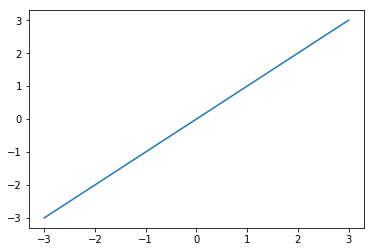

In [15]:
plt.plot(x, y)

In [16]:
fixed_z = torch.tensor( np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]), dtype=torch.float )

In [17]:
fixed_z.shape

torch.Size([100, 2])

In [18]:
k='AE2'
fixed_gen = models[k].decode(fixed_z.to(device)).to('cpu').data.numpy()


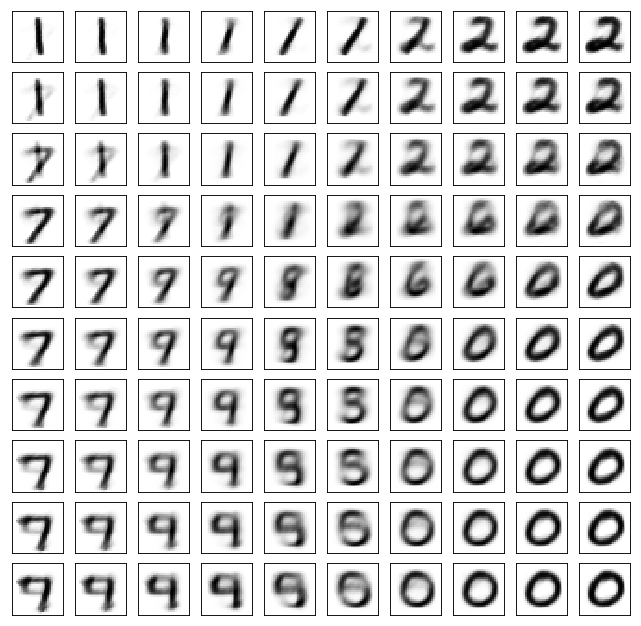

In [19]:
plot_mnist(fixed_gen.reshape(-1,1,28,28), (10, 10))


In [20]:
fixed_data, _ = next(iter(test_loader))

In [21]:
fixed_data.shape

torch.Size([100, 1, 28, 28])

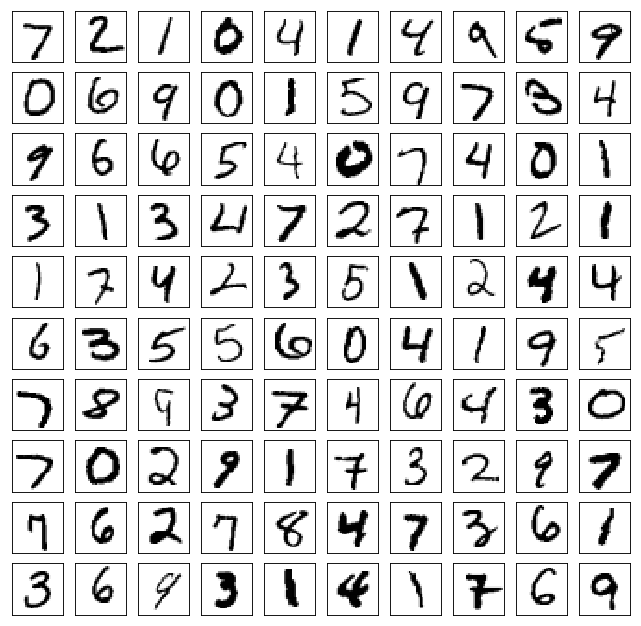

In [22]:
# plot input data
plot_mnist(fixed_data.to('cpu').data.numpy(), (10, 10))

In [23]:
with torch.no_grad():
    model_data = models[k](fixed_data.to(device))

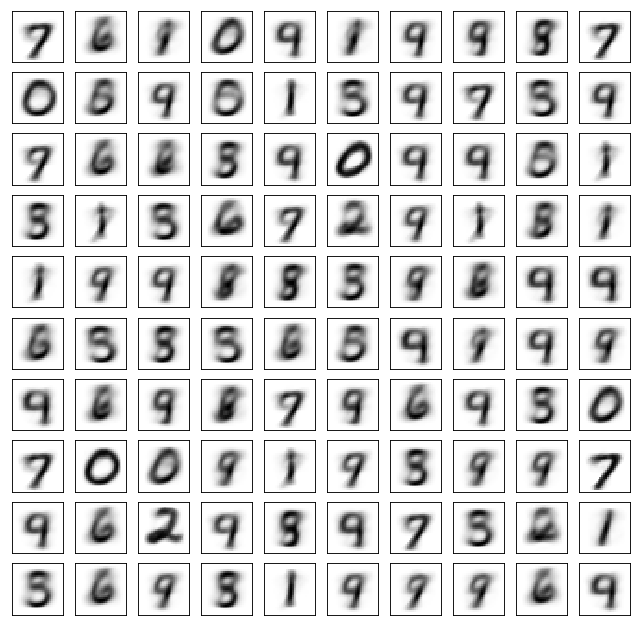

In [24]:
# plot output data
plot_mnist(model_data.to('cpu').data.numpy().reshape(-1,1,28,28), (10, 10))